# Loading the data

In [1]:
# @title Install dependencies

#!pip install pandas --quiet
#!pip install seaborn --quiet
#!pip install  pyarrow # may be needed to read data file

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# from sklearn.decomposition import PCA             # just if needed
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Ridge

## For this example, we have pre-computed event triggered responses and saved them to figshare.
#### To access the full dataset, see `Allen_neuromatch_example_2.ipynb`, or go to the links at the bottom of this notebook
###This cell will download the responses.

In [3]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

### Then we open it using the pandas `read_parquet` method


(parquet is just another file format)

In [4]:
filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(filename)

# DATA_ PROCESSING: Start here after loading data

In [5]:
#THIS IS WHERE THE FUN STARTS
# Define a function to map combinations to numbers 1-4
def map_conditions(row):
    if row['exposure_level'] == "familiar" and row['is_change'] == True:
        return 1
    elif row['exposure_level'] == "familiar" and row['is_change'] == False:
        return 2
    elif row['exposure_level'] == "novel" and row['is_change'] == True:
        return 3
    elif row['exposure_level'] == "novel" and row['is_change'] == False:
        return 4


# Apply the function to create the new column
#filtered_df['condition'] = filtered_df.apply(map_conditions, axis=1)

#print(filtered_df.shape)

In [6]:
data['condition'] = data.apply(map_conditions, axis=1)

In [7]:
outliers = []
data_traces = data.trace.values
for i in range(len(data_traces)):
    outliers.append((data_traces[i]<1).all())

data_subset_rmo = data[outliers]

In [8]:
def restrict_neurons_with_all_conditions(df):
    # Group by neuron and find unique conditions for each neuron
    neuron_conditions = df.groupby('cell_specimen_id')['condition'].unique()
    # filtering only neurons that have trials in all 4 conditions
    neurons_with_all_conditions = neuron_conditions[
        neuron_conditions.apply(lambda x: {1, 2, 3, 4}.issubset(x))
    ].index
    # Filter the data for those neurons
    filtered_d = df[df['cell_specimen_id'].isin(neurons_with_all_conditions)]
    return filtered_d
filtered_data = restrict_neurons_with_all_conditions(data_subset_rmo)

In [9]:
def verify_filtered_data(df):
    condition_counts = df.groupby('cell_specimen_id')['condition'].nunique()
    return (condition_counts == 4).all()
print(f"Verification result: {verify_filtered_data(filtered_data)}")

Verification result: True


In [10]:
#how many trials of each type per neuron? -> calculate length of each condition for each neuron - creating the trial counts variable
# Group by cell_id and 'condition', then count the number of occurrences
trial_counts = filtered_data.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts)


     cell_specimen_id  condition  trial_count
0          1086489847          1          204
1          1086489847          2          190
2          1086489847          3          218
3          1086489847          4          217
4          1086489860          1          203
..                ...        ...          ...
383        1086567017          4          184
384        1086567589          1          493
385        1086567589          2          304
386        1086567589          3          303
387        1086567589          4          152

[388 rows x 3 columns]


In [11]:
# Group by 'condition' and find the minimum 'trial_count' for each condition
min_trial_counts = trial_counts.groupby('condition')['trial_count'].min().reset_index()

# For each condition, find the neuron_id corresponding to the minimum trial_count
#min_trial_neurons = trial_counts.loc[trial_counts.groupby('condition')['trial_count'].idxmin()].reset_index(drop=True)

# Merge the two dataframes to get the condition, trial_count, and neuron_id together
#result = pd.merge(min_trial_counts, min_trial_neurons, on=['condition', 'trial_count'], suffixes=('', '_min'))

# Select only the relevant columns
min_trial_counts = min_trial_counts[['condition', 'trial_count']]

print(min_trial_counts)

   condition  trial_count
0          1          122
1          2          127
2          3           82
3          4          101


In [12]:
#ALTERNATIVE OPTION
# Sort the dataframe by 'condition' and 'trial_count' - in case we did not want the minimum but another benchmark
sorted_trial_counts = trial_counts.sort_values(by=['condition', 'trial_count'])

# Group by 'condition' and take the nth smallest 'trial_count'
second_trial_counts = sorted_trial_counts.groupby('condition').nth(0).reset_index()

print(second_trial_counts)

   condition  cell_specimen_id  trial_count
0          1        1086498976          122
1          2        1086495377          127
2          3        1086490603           82
3          4        1086498820          101


Now we need to get all neurons to have the same number of trials per condition. 

In [13]:
#CALCULATE MIN TRIALS
# Calculate the minimum number of trials for each condition
min_trials_per_condition = trial_counts.groupby('condition')['trial_count'].min()
min_trials_per_condition

condition
1    122
2    127
3     82
4    101
Name: trial_count, dtype: int64

In [14]:
#MIN_TRIALS DICTIONARY
# Convert min_trials_df to a dictionary for quick lookup
min_trials_dict = min_trials_per_condition.to_dict()
print(min_trials_dict)

{1: 122, 2: 127, 3: 82, 4: 101}


In [15]:
# Function to sample trials
def sample_trials(group, min_trials_dict, random_seed=42):
    condition = group['condition'].iloc[0]  # Extract condition from group
    min_trials = min_trials_dict.get(condition, None)  # Get minimum trials for the condition
    if min_trials is not None and len(group) > min_trials:
        return group.sample(min_trials, random_state=random_seed)
    return group


In [16]:
# Group by 'cell_id' and 'condition', then sample trials to match the minimum
balanced_df = (
    filtered_data.groupby(['cell_specimen_id', 'condition'], group_keys=False)
    .apply(lambda x: sample_trials(x, min_trials_dict))
)

#print(balanced_df)

In [17]:
#CHECKS WHETHER THINGS WORKED
#how many trials of each type per neuron? -> calculate length of each condition for each neuron
# Group by cell_id and 'condition', then count the number of occurrences
print(min_trials_dict)
trial_counts2 = balanced_df.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts2)

{1: 122, 2: 127, 3: 82, 4: 101}
     cell_specimen_id  condition  trial_count
0          1086489847          1          122
1          1086489847          2          127
2          1086489847          3           82
3          1086489847          4          101
4          1086489860          1          122
..                ...        ...          ...
383        1086567017          4          101
384        1086567589          1          122
385        1086567589          2          127
386        1086567589          3           82
387        1086567589          4          101

[388 rows x 3 columns]


array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>]],
      dtype=object)

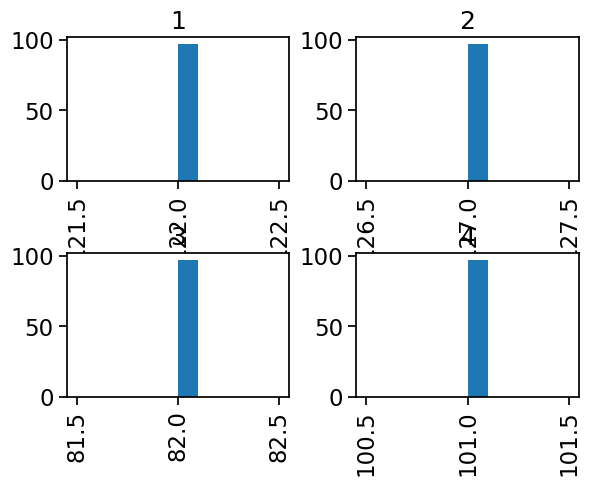

In [18]:
trial_counts2.hist(column='trial_count', by="condition")

In [19]:
# Check if all neurons have the minimum number of trials per condition
correct_counts = trial_counts2.groupby('condition')['trial_count'].nunique() == 1

print("All neurons have the same number of trials per condition:")
print(correct_counts)

All neurons have the same number of trials per condition:
condition
1    True
2    True
3    True
4    True
Name: trial_count, dtype: bool


## Creating feature matrix X and target array y

### Get columns of interest 
(incl. neuron_types for follow-up question, i.e., model for VIP to predict SST)

In [20]:
#### Get needed features to reshape matrix (next cell) ###
df_features = balanced_df.copy()

# Label encoding SST & VIP (also for figures later)
df_features['neuron_type'] = df_features.loc[:,'cre_line'].replace({'Sst-IRES-Cre':'SST', 'Vip-IRES-Cre':'VIP'})
df_features = df_features.loc[:,['cell_specimen_id', 'neuron_type','condition','trace', 'trace_timestamps']]

df_features.sample(5)

,cell_specimen_id,neuron_type,condition,trace,trace_timestamps
1174414,1086561466,VIP,2,"[-0.08431426435709, 0.15257048606872559, 0.099...","[-1.2281906028244671, -1.1958697974869812, -1...."
121157,1086497550,SST,1,"[0.04333176836371422, 0.09298921376466751, 0.0...","[-1.2281638329897349, -1.195843732121584, -1.1..."
1017862,1086489891,VIP,4,"[-0.011415318585932255, 0.05542634055018425, -...","[-1.227986488876192, -1.1956710549583975, -1.1..."
1573041,1086490751,SST,4,"[0.00286138360388577, -0.007981499657034874, 0...","[-1.228044985469164, -1.1957280121673437, -1.1..."
512783,1086501601,VIP,1,"[-0.04788321256637573, -0.042395904660224915, ...","[-1.2279363490103425, -1.1956222345627021, -1...."


### Time stamps in s (for figures)

In [22]:
# Store timestamps in seconds - for figures
timestamps = df_features.loc[:,'trace_timestamps'].iloc[0]
timestamps = (timestamps - timestamps[0]).round(2) # in s
timestamps

array([0.  , 0.03, 0.06, 0.1 , 0.13, 0.16, 0.19, 0.23, 0.26, 0.29, 0.32,
       0.36, 0.39, 0.42, 0.45, 0.48, 0.52, 0.55, 0.58, 0.61, 0.65, 0.68,
       0.71, 0.74, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.94, 0.97, 1.  , 1.03,
       1.07, 1.1 , 1.13, 1.16, 1.2 , 1.23, 1.26, 1.29, 1.32, 1.36, 1.39,
       1.42, 1.45, 1.49, 1.52, 1.55, 1.58, 1.62, 1.65, 1.68, 1.71, 1.75,
       1.78, 1.81, 1.84, 1.87, 1.91, 1.94, 1.97, 2.  , 2.04, 2.07, 2.1 ,
       2.13, 2.17, 2.2 , 2.23, 2.26, 2.29, 2.33, 2.36, 2.39, 2.42, 2.46,
       2.49, 2.52, 2.55, 2.59, 2.62, 2.65, 2.68, 2.71])

### Reshape feature matrix - one row per timepoint

In [ ]:
### Reshape feature matrix (takes several minutes!) ###
# ... for this purpose, first, create a feature list (i.e., a list of rows)
feature_list = []
count_t = 0
for idx, neuron_id in enumerate(df_features.cell_specimen_id.unique()): 
    
    # Initialize neuron data frame
    df_neuron = df_features[df_features.cell_specimen_id == neuron_id].copy()
    print('neuron', idx+1,'/ 97') # just to see that it's running
    
    # Select trace (or trial)
    for trace_id in range(1,sum(min_trial_counts.trial_count)+1): # 1 to 432 trials
        
        # Get condition (1,2,3,4) 
        tmp_conditions = df_neuron.loc[:,'condition']
        
        # Built reshaped feature matrix 
        for t in range(0,len(df_features.trace.values[0]) ): # 85 time points 
            feature_list.append([
                df_neuron.loc[:,'neuron_type'].iloc[0],       # neuron type (VTT or SST) 
                neuron_id,                                    # specific neuron id             
                tmp_conditions.iloc[trace_id-1],              # novelty condition
                trace_id,                                     # trace id (between 1 and 432 for each neuron)
                df_neuron.loc[:,'trace'].iloc[trace_id-1][t], # trace at this time point
                t])                                           # time point within the current trace  


In [24]:
# Reshaped data frame (~ 1min)
new_columns = ['neuron_type','neuron_id','condition','trace_id','trace','timepoint']
df_reshaped = pd.DataFrame(feature_list, columns = new_columns)

df_reshaped.tail(10)

,neuron_type,neuron_id,condition,trace_id,trace,timepoint
3561830,VIP,1086567589,4,432,-0.008837,75
3561831,VIP,1086567589,4,432,-0.012395,76
3561832,VIP,1086567589,4,432,-0.060496,77
3561833,VIP,1086567589,4,432,-0.028067,78
3561834,VIP,1086567589,4,432,-0.154335,79
3561835,VIP,1086567589,4,432,-0.031324,80
3561836,VIP,1086567589,4,432,-0.013424,81
3561837,VIP,1086567589,4,432,-0.162069,82
3561838,VIP,1086567589,4,432,-0.159199,83
3561839,VIP,1086567589,4,432,-0.018913,84


### Feature matrix X and target y

In [25]:
# Feature matrix X and target y
X = df_reshaped.loc[:,['neuron_id','trace','timepoint']]  # df_reshaped.drop(columns = ['condition'])
y = df_reshaped.loc[:,['condition','timepoint']]

display(X.shape, y.shape, X.head(), y.sample(5))

(3561840, 3)

(3561840, 2)

,neuron_id,trace,timepoint
0,1086489847,-0.002927,0
1,1086489847,0.006589,1
2,1086489847,-0.019372,2
3,1086489847,0.002999,3
4,1086489847,-0.047786,4


,condition,timepoint
3538039,2,84
1683177,4,7
1402427,1,12
893535,2,15
3469069,2,49


# Logistic Regression Models

## Instantiate Pipeline

In [51]:
### Instantiate Logistic Regression Model ###
from sklearn.pipeline import Pipeline

# Create a pipeline for Logistic Regression 
Cs = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
pipe_logistic = Pipeline([
    ('std', StandardScaler()), # 'pca', PCA(n_components = 0.9) # just if needed to reduce noise or improve the prediction(s)
    ('logReg',  LogisticRegressionCV(random_state = 0, cv = 10, penalty='l2', Cs=Cs, max_iter=1000, n_jobs=-1) ) # 10 fold cross validation
   ])

## Regression models with one train-test split

In [ ]:
### Split the data into training and test sets ###
X_train, X_test,y_train, y_test = train_test_split(
    X, y,
    test_size = 0.1, 
    random_state = 0
)

# Testing on 10% of the data
print('Training: \nX:',X_train.shape, '\ny:', y_train.shape)# '\nTesting:', df_test.shape)
print('Testing: \nX:',X_test.shape, '\ny:', y_test.shape)# '\nTesting:', df_test.shape)

### Train one model at each time point and save their prediction accuracy ###
from sklearn.metrics import accuracy_score, confusion_matrix
# Number of time points
T = X_train.shape[0]
# Instantiate arrays containing 
# ...the accuracy score and confidence matrix for each time point
acc = []
conf_mat = []

timepoints = X.loc[:,'timepoint'].unique()
for t in timepoints:
    print(t)

    # Get feature (trace) and target (condition)
    # ...for training
    tmp_X_train = X_train[X_train.loc[:,'timepoint'] == t].loc[:,['neuron_id','trace']] # all traces at timepoint t
    tmp_y_train = y_train[y_train.loc[:,'timepoint'] == t].loc[:,'condition'] # 'novelty' conditions [1,2,3,4] 

    # ... for testing
    tmp_X_test = X_test[X_test.loc[:,'timepoint'] == t].loc[:,['neuron_id','trace']]
    tmp_y_test = y_test[y_test.loc[:,'timepoint'] == t].loc[:,'condition'] 

    # Fit 
    pipe_logistic.fit(tmp_X_train, tmp_y_train)

    # Predict
    tmp_y_pred = pipe_logistic.predict(tmp_X_test)
    
    # Store accuracy of this prediction
    acc.append(accuracy_score(tmp_y_test, tmp_y_pred)) # = sum(y_pred[t]==y_test)/len(y_test)
    conf_mat.append(confusion_matrix(tmp_y_test, tmp_y_pred))
   

In [79]:
# In this case, the model with the simple split shows the higher maximal accuracy
# Maximum
display(max(acc))
# Chance level
chance = np.max(min_trial_counts.trial_count.values/sum(min_trial_counts.trial_count) )

0.353415559772296

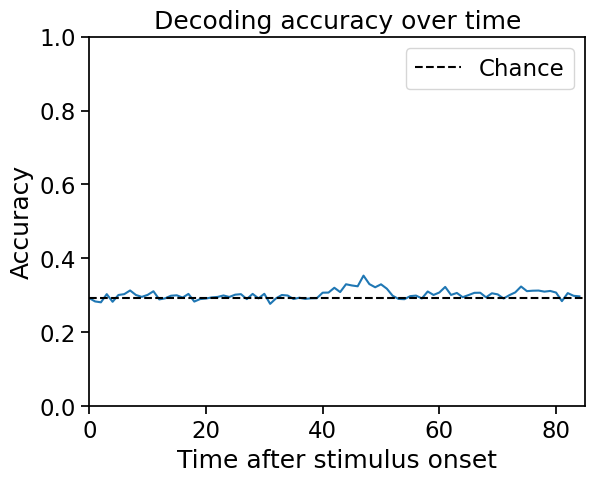

In [77]:
# Accuracy plot
plt.subplot()
plt.plot(range(len(acc)), acc)
plt.xlabel('Time after stimulus onset')
plt.ylabel('Accuracy')
plt.hlines(y=chance, xmin=0, xmax=T, label='Chance', linestyles='dashed', colors='black')
plt.legend()
plt.ylim((0,1))
plt.xlim((0,85))
plt.title("Decoding accuracy over time")
plt.show()

## Regression models with multiple (ten) train-test splits
*(StratifiedKFold - more useful for unbalanced conditions, cf. simple split)*

In [80]:
### Split the data into training and test sets ###
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix


n_folds = 10 # number of folds for k-fold CV
folds   = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 123) # initialize folds generator

# Instantiate arrays containing 
# ...the accuracy score and confidence matrix for each time point
acc_2      = []
conf_mat_2 = []

# Timepoints (0 to 84)
timepoints = X.loc[:,'timepoint'].unique()
count = 0
for train_index, test_index in folds.split(X, y.loc[:,'condition']): # loop over k folds using the training and test indices from StratifiedKFold
    count = count + 1
    print('Fold', count,'...')
    
    # Split into training and test set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for t in timepoints:

        # Get feature (trace) and target (condition)
        # ...for training
        tmp_X_train = X_train[X_train.loc[:,'timepoint'] == t].loc[:,['neuron_id','trace']] # all traces at timepoint t
        tmp_y_train = y_train[y_train.loc[:,'timepoint'] == t].loc[:,'condition'] # 'novelty' conditions [1,2,3,4] 

        # ... for testing
        tmp_X_test = X_test[X_test.loc[:,'timepoint'] == t].loc[:,['neuron_id','trace']]
        tmp_y_test = y_test[y_test.loc[:,'timepoint'] == t].loc[:,'condition'] 

        # Fit 
        pipe_logistic.fit(tmp_X_train, tmp_y_train)

        # Predict
        tmp_y_pred = pipe_logistic.predict(tmp_X_test)
    
        # Store accuracy of this prediction
        # print(accuracy_score(tmp_y_test, tmp_y_pred))
        acc_2.append(accuracy_score(tmp_y_test, tmp_y_pred)) # = sum(y_pred[t]==y_test)/len(y_test)
        conf_mat_2.append(confusion_matrix(tmp_y_test, tmp_y_pred))

print('Done')

Fold 1 ...
Fold 2 ...
Fold 3 ...
Fold 4 ...
Fold 5 ...
Fold 6 ...
Fold 7 ...
Fold 8 ...
Fold 9 ...
Fold 10 ...
Done


In [116]:
#### TO DO: calculate correct accuracy ####
# Maximum
display(max(acc_2))

acc_2_array    =  np.asarray(acc_2)
reshaped_array = acc_2_array.reshape(85,10)
max(reshaped_array.mean(axis = 1))

# Chance level
#chance = np.max(min_trial_counts.trial_count.values/sum(min_trial_counts.trial_count))

0.3414461247637051

0.323651024057333

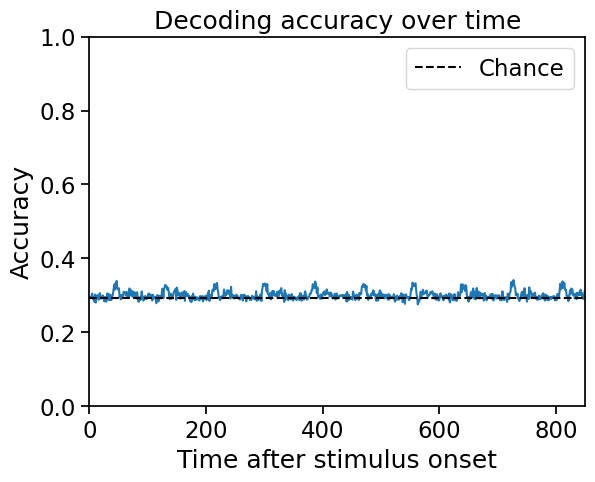

In [82]:
# Accuracy plot
plt.subplot()
plt.plot(range(len(acc_2)), acc_2)
plt.xlabel('Time after stimulus onset')
plt.ylabel('Accuracy')
plt.hlines(y=chance, xmin=0, xmax=T, label='Chance', linestyles='dashed', colors='black')
plt.legend()
plt.ylim((0,1))
plt.xlim((0,len(acc_2)))
plt.title("Decoding accuracy over time")
plt.show()